# Import Tensorflow and Pytorch Libraries

In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np

# 01. Load Dataset

In [4]:
import pandas as pd

airfoil_df = pd.read_csv('airfoil_self_noise.dat', sep = '\t')

airfoil_df.head()

,800,0,0.3048,71.3,0.00266337,126.201
0,1000,0.0,0.3048,71.3,0.002663,125.201
1,1250,0.0,0.3048,71.3,0.002663,125.951
2,1600,0.0,0.3048,71.3,0.002663,127.591
3,2000,0.0,0.3048,71.3,0.002663,127.461
4,2500,0.0,0.3048,71.3,0.002663,125.571


# 02. Clean the Data & Find Missing Values

In [5]:
airfoil_df.dtypes

800             int64
0             float64
0.3048        float64
71.3          float64
0.00266337    float64
126.201       float64
dtype: object

In [6]:
airfoil_df.isnull().sum(axis = 0)

800           0
0             0
0.3048        0
71.3          0
0.00266337    0
126.201       0
dtype: int64

In [7]:
airfoil_df.describe()

,800,0,0.3048,71.3,0.00266337,126.201
count,1502.000000,1502.000000,1502.000000,1502.000000,1502.000000,1502.000000
mean,2887.769640,6.786818,0.136436,50.847137,0.011146,124.835034
std,3153.162983,5.917509,0.093471,15.569029,0.013153,6.900864
min,200.000000,0.000000,0.025400,31.700000,0.000401,103.380000
25%,800.000000,2.000000,0.050800,39.600000,0.002535,120.190000
50%,1600.000000,5.400000,0.101600,39.600000,0.004957,125.719000
75%,4000.000000,9.900000,0.228600,71.300000,0.015840,129.997750
max,20000.000000,22.200000,0.304800,71.300000,0.058411,140.987000


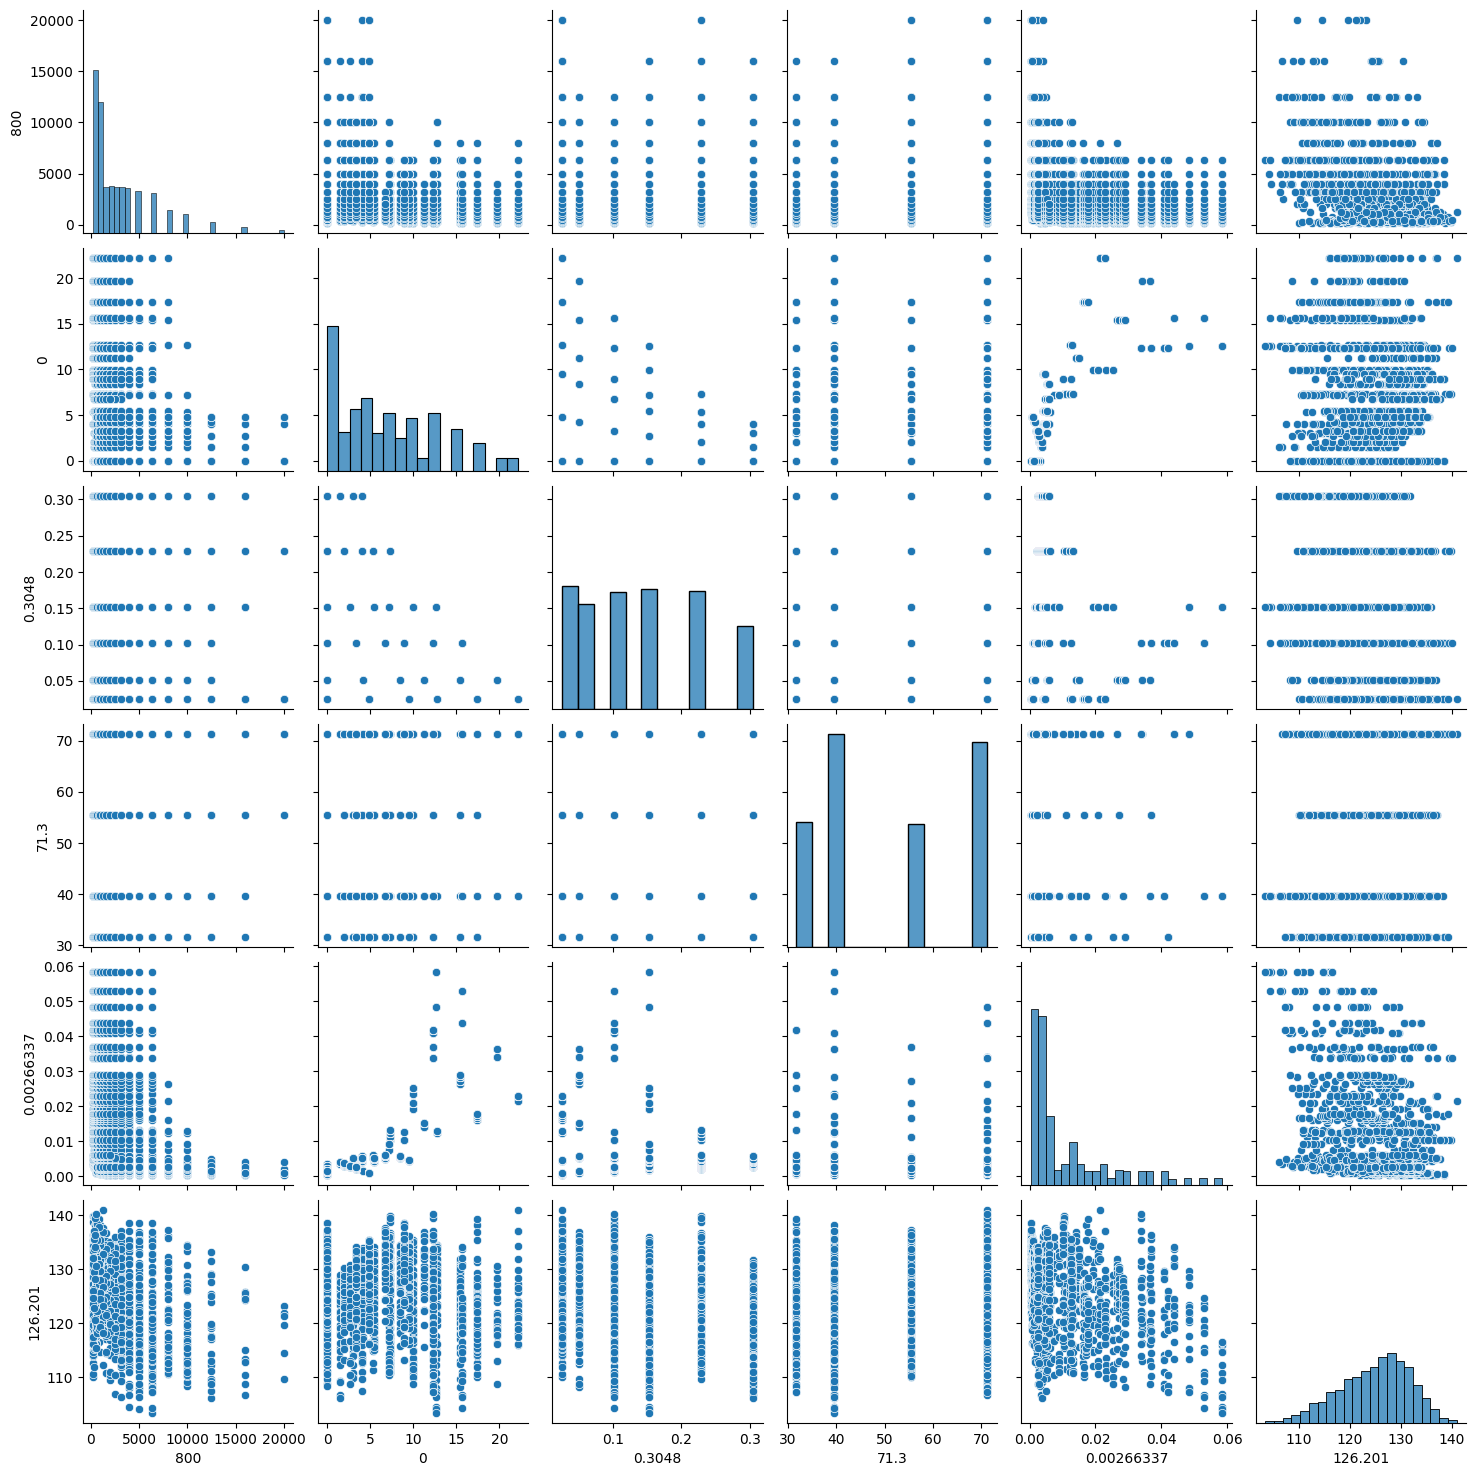

In [8]:
import seaborn as sns

sns.pairplot(airfoil_df)

# 03. Train-Test Split & Build Liner Regression Model to Forecast 'Scaled sound pressure level'

In [32]:
X = airfoil_df.drop('126.201', axis = 1)
y = airfoil_df['126.201']


from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state = 42)

In [33]:
print(f"Shape of X Train: {X_train.shape} \nShape of Y Train: {y_train.shape}")
print(f"Shape of X Test: {X_test.shape} \nShape of Y Test: {y_test.shape}")

Shape of X Train: (1201, 5) 
Shape of Y Train: (1201,)
Shape of X Test: (301, 5) 
Shape of Y Test: (301,)


In [34]:
from sklearn.linear_model import LinearRegression

linear_model = LinearRegression()

linear_model.fit(X_train, y_train)

y_pred = linear_model.predict(X_test)

In [35]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

airfoil_mse = mean_squared_error(y_test, y_pred)
airfoil_rmse = mean_squared_error(y_test, y_pred, squared = False)
airfoil_absolute_mse = mean_absolute_error(y_test, y_pred)


print(f"The mean square error is: \t {airfoil_mse.round(4)}")
print(f"The root of mean square error is: {airfoil_rmse.round(4)}")
print(f"The mean absolute error is: \t  {airfoil_absolute_mse.round(4)}")

The mean square error is: 	 21.2594
The root of mean square error is: 4.6108
The mean absolute error is: 	  3.5535


# 04. Preprocessing and Normalizing the Data

In [76]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range = (0,1))

X_train = scaler.fit_transform(X_train)

X_test = scaler.transform(X_test)

print(X_train.shape, "\n", X_test.shape)

(1201, 5) 
 (301, 5)


# TensorFlow

In [85]:
tensorflow_linear_reg_model = keras.Sequential(
    [
        # first layer neurons
        layers.Dense(250_000, activation='relu'),
        #last layer has one and only one neuron
        layers.Dense(1),
    ]
)

tensorflow_linear_reg_model.compile(optimizer='adam', loss='mse')

In [86]:
tf.random.set_seed(42)
tensorflow_linear_reg_model.fit(x=X_train,
                                y=y_train,
                                batch_size=64,
                                epochs=100,
                                validation_data=(X_test,y_test)
                                )

Epoch 1/100
19/19 [==============================] - 1s 22ms/step - loss: 8825.0010 - val_loss: 1134.5104
Epoch 2/100
19/19 [==============================] - 0s 10ms/step - loss: 1446.8608 - val_loss: 1234.3406
Epoch 3/100
19/19 [==============================] - 0s 9ms/step - loss: 810.0691 - val_loss: 635.4728
Epoch 4/100
19/19 [==============================] - 0s 9ms/step - loss: 471.6911 - val_loss: 413.7039
Epoch 5/100
19/19 [==============================] - 0s 9ms/step - loss: 308.4717 - val_loss: 265.6636
Epoch 6/100
19/19 [==============================] - 0s 9ms/step - loss: 185.7437 - val_loss: 150.3550
Epoch 7/100
19/19 [==============================] - 0s 9ms/step - loss: 107.9997 - val_loss: 88.3031
Epoch 8/100
19/19 [==============================] - 0s 11ms/step - loss: 66.8520 - val_loss: 59.7461
Epoch 9/100
19/19 [==============================] - 0s 9ms/step - loss: 47.9974 - val_loss: 45.2279
Epoch 10/100
19/19 [==============================] - 0s 9ms/step - los

In [87]:
y_pred = tensorflow_linear_reg_model.predict(X_test)

10/10 [==============================] - 0s 2ms/step


In [88]:
airfoil_mse = mean_squared_error(y_test, y_pred)
airfoil_rmse = mean_squared_error(y_test, y_pred, squared = False)
airfoil_absolute_mse = mean_absolute_error(y_test, y_pred)


print(f"The mean square error is: \t {airfoil_mse.round(4)}")
print(f"The root of mean square error is: {airfoil_rmse.round(4)}")
print(f"The mean absolute error is: \t  {airfoil_absolute_mse.round(4)}")

The mean square error is: 	 15.6959
The root of mean square error is: 3.9618
The mean absolute error is: 	  2.9413


Originally the MSE (Mean Square Error) was around 100-200, but after tuning:  
- Number of Neurons: 250_000
- Random Set Seed: 42


Result of MSE: 15.696

# PyTorch

In [18]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state = 42)

In [19]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train= scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [20]:
X_train = torch.tensor(X_train.astype(np.float32))
y_train = torch.tensor(y_train.values.astype(np.float32).reshape(-1,1))

In [21]:
input_size = X_train.shape[1]
output_size = y_train.shape[1]

#specify the number of neuron for the first layer
hidden_size = 500_000
print(input_size)
print(output_size)

5
1


In [22]:
# define the child module class derivated from parent class of torch.nn.Module)
class LinearRegressionModel(torch.nn.Module):
    #define the constructor
    def __init__(self, input_size, hidden_size, output_size):
        super(LinearRegressionModel, self).__init__()
        self.hidden = torch.nn.Linear(input_size, hidden_size)
        self.predict = torch.nn.Linear(hidden_size, output_size)
    #overwrite the forward function in this child class
    def forward(self, x):
        x = F.relu(self.hidden(x))
        y_pred = self.predict(x)
        return y_pred

In [23]:
pytorch_airfoil_model = LinearRegressionModel(input_size, hidden_size, output_size)

In [24]:
l = nn.MSELoss()

In [25]:
optimizer = torch.optim.Adam(pytorch_airfoil_model.parameters(), lr=0.05)

In [26]:
#fix the random seeds for torch and np
torch.manual_seed(42)
np.random.seed(42)

#set the number of epochs
num_epochs = 100
for epoch in range(num_epochs):
    #forward pass
    y_pred = pytorch_airfoil_model(X_train.requires_grad_())

    #calculate the loss
    loss = l(y_pred, y_train)
    #Set the gradients to be zero
    optimizer.zero_grad()

    #backward pass: calculate gradients
    loss.backward()

    #update the weights
    optimizer.step()

    print('epoch {0}, loss:{1:.4f}'.format(epoch, loss.item()))

epoch 0, loss:15638.4365
epoch 1, loss:14539310.0000
epoch 2, loss:457774.5625
epoch 3, loss:779454.0000
epoch 4, loss:1960066.5000
epoch 5, loss:1821086.1250
epoch 6, loss:1131906.7500
epoch 7, loss:567516.0000
epoch 8, loss:259506.5469
epoch 9, loss:119822.9219
epoch 10, loss:60694.3477
epoch 11, loss:35708.3594
epoch 12, loss:24828.6250
epoch 13, loss:19939.2852
epoch 14, loss:17693.3496
epoch 15, loss:16648.0723
epoch 16, loss:16153.4150
epoch 17, loss:15911.2275
epoch 18, loss:15787.7568
epoch 19, loss:15720.7041
epoch 20, loss:15681.6602
epoch 21, loss:15657.2139
epoch 22, loss:15640.9473
epoch 23, loss:15629.4883
epoch 24, loss:15620.9941
epoch 25, loss:15614.4033
epoch 26, loss:15609.0693
epoch 27, loss:15604.5830
epoch 28, loss:15600.6875
epoch 29, loss:15597.2090
epoch 30, loss:15594.0332
epoch 31, loss:15591.0703
epoch 32, loss:15588.2715
epoch 33, loss:15585.5908
epoch 34, loss:15582.9961
epoch 35, loss:15580.4678
epoch 36, loss:15577.9883
epoch 37, loss:15575.5439
epoch 38

In [27]:
#convert numpy to tensor
X_test = torch.from_numpy(X_test.astype(np.float32))
#Stop tracking the gradient by calling detach since we don't use it anymore
y_pred = pytorch_airfoil_model(X_test).detach().numpy()

In [28]:
airfoil_mse = mean_squared_error(y_test, y_pred)
airfoil_rmse = mean_squared_error(y_test, y_pred, squared = False)
airfoil_absolute_mse = mean_absolute_error(y_test, y_pred)


print(f"The mean square error is: \t {airfoil_mse.round(4)}")
print(f"The root of mean square error is: {airfoil_rmse.round(4)}")
print(f"The mean absolute error is: \t  {airfoil_absolute_mse.round(4)}")

The mean square error is: 	 15358.8417
The root of mean square error is: 123.9308
The mean absolute error is: 	  123.7346


After tuning the:

- Manual Seed: 42
- Random Seed: 42
- Hidden Size: 500_000

MSE Result: 15_358.8417